In [3]:
import glob
import joblib
import fitsio
import os
import numpy as np
import meds
import tqdm

from meds.defaults import BMASK_EDGE

import proplot as pplt

BINS = np.linspace(-20, 20, 41) + 0.5
BANDS = ["g", "r", "i", "z", "Y"]
BCEN = (BINS[:-1] + BINS[1:])/2

In [27]:
def _convert_to_index(row, col, dbox=100, edge=50):
    xind = (col.astype(int) - edge)//dbox
    yind = (row.astype(int) - edge)//dbox
    num = (10_000 - edge - edge) // dbox
    return xind + num*yind


def _compute_hist_for_tile_band(pizza_name, stamp_name, dbox, edge):
    max_pizz_ind = ((10_000 - edge - edge)//dbox)**2
    
    if (not os.path.exists(pizza_name)) or (not os.path.exists(stamp_name)):
        return None

    with meds.MEDS(pizza_name) as m, meds.MEDS(stamp_name) as mobj:
        pizza_inds = _convert_to_index(
            mobj["orig_row"][:, 0], 
            mobj["orig_col"][:, 0], 
            dbox=dbox, edge=edge
        )
        assert np.array_equal(
            _convert_to_index(m["orig_row"][:, 0], m["orig_col"][:, 0], dbox=dbox, edge=edge),
            np.arange(len(m["orig_col"][:, 0]), dtype=int),
        )

        dnepoch = []
        nepoch = []
        for obj_ind, pizza_ind in tqdm.tqdm(
            enumerate(pizza_inds), total=len(pizza_inds)
        ):
            if pizza_ind < 0 or pizza_ind >= max_pizz_ind or m["nepoch"][pizza_ind] <= 0:
                continue

            nepoch_obj = 0
            for msk_ind in range(1, mobj["ncutout"][obj_ind]):
                msk = mobj.get_cutout(obj_ind, msk_ind, type="bmask")
                if not np.any(msk & BMASK_EDGE):
                    nepoch_obj += 1
            dnepoch.append(m["nepoch"][pizza_ind] - nepoch_obj)
            nepoch.append(nepoch_obj)

    return np.array(nepoch) + np.array(dnepoch), np.array(nepoch), np.array(dnepoch)

In [28]:
big_pizza_name = "DES2229-3957_r_des-pizza-slices-y6-v9_meds-pizza-slices.fits.fz"
small_pizza_name = "DES2229-3957_r_des-pizza-slices-y6-v9-small_meds-pizza-slices.fits.fz"
stamp_name = "meds/DES2229-3957_r4575p01_r_meds-Y6A1.fits.fz"

sres = _compute_hist_for_tile_band(small_pizza_name, stamp_name, 50, 50)
bres = _compute_hist_for_tile_band(big_pizza_name, stamp_name, 100, 50)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60183/60183 [00:16<00:00, 3662.80it/s]


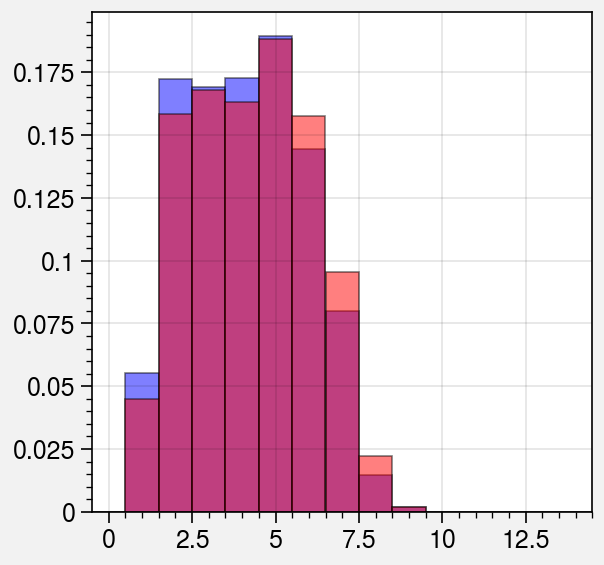

In [29]:
fig, axs = pplt.subplots()

axs.hist(bres[0], bins=BINS, color='b', alpha=0.5, density=True)
axs.hist(sres[0], bins=BINS, color='r', alpha=0.5, density=True)
axs.format(xlim=(-0.5, 14.5))

In [33]:
np.mean(sres[0]), np.mean(bres[0])

(4.27024339266451, 4.105670190132045)